In [168]:
import os
import sys
import numpy as np
import pandas as pd
import re
from prophet import Prophet
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [169]:
df = pd.read_csv('air-traffic-prediction/parkingLot.csv')
df_orignal=pd.read_csv('air-traffic-prediction/parkingLot_missing_values.csv')

In [170]:
def normalCleaning(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by='timestamp')
    df = df[df['vehicle_no'].notna()]
    df = df.dropna()
    df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
    df = df.drop_duplicates()
    # print(df.shape)
    return df

In [171]:
def valid_vehicle_no(vehicle_no):
    pattern = r'^[M][H][0-9]{2}[A-Z]{1,2}[0-9]{4}$'
    return bool(re.match(pattern=pattern, string=vehicle_no))

# ndf=df[df['vehicle_no'].apply(valid_vehicle_no)]
# df

In [172]:
def mergeByTime(df):
    entry_df = df[df['camera_id'] == 1]  # Entries (camera_id = 001)
    exit_df = df[df['camera_id'] == 2]   # Exits (camera_id = 002)
    # print(df)
    # 2. Rename columns for clarity
    entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
    exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})
    merged_df = pd.merge(entry_df[['vehicle_no', 'in_time']], 
                        exit_df[['vehicle_no', 'exit_time']], 
                        on='vehicle_no', 
                        how='left')

    merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
    merged_df['timestamp_exit'] = pd.to_datetime(arg=merged_df['exit_time'])

    # Ensure timestamps are on the same date by comparing just the date part
    merged_df = merged_df[
        (merged_df['in_time'].dt.date == merged_df['exit_time'].dt.date) &
        (merged_df['in_time'] <= merged_df['exit_time'])
    ]
    merged_df= merged_df.dropna()
    merged_df['in_time'] = pd.to_datetime(merged_df['in_time'])
    merged_df['date'] = merged_df['in_time'].dt.date
    return merged_df


In [173]:



def daily_entries_plot(merged_df):

    # 2. Group by 'date' and count the number of entries per day
    entries_daily = merged_df.groupby('date')['vehicle_no'].count()
    entries_daily.index = pd.to_datetime(entries_daily.index)


    # Sort the data by date (this step ensures it's chronological)
    entries_daily = entries_daily.sort_index()

    # 1. Split the data into train and test sets
    # Use all but the last 7 days for training, and the last 7 days for testing
    train_data = entries_daily.iloc[:-7]  # All data except the last 7 days
    test_data = entries_daily.iloc[-7:] 

    # 3. Plot the total number of vehicles entering per day
    # plt.figure(figsize=(10, 6))
    # train_data.plot(kind='line', marker='o')
    # plt.title('Total Number of Vehicles Entering the Parking Per Day')
    # plt.xlabel('Date')
    # plt.ylabel('Number of Vehicles Entering')
    # plt.grid(True)
    # plt.xticks(rotation=45)  # Rotate date labels for better readability
    # plt.tight_layout()
    # plt.show()
    return train_data,test_data

In [174]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Calculate Mean Absolute Scaled Error (MASE).
    
    :param y_true: Array-like, true values
    :param y_pred: Array-like, predicted values
    :return: float, MASE value
    """
    # Calculate the mean absolute error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the naive forecast errors
    naive_forecast = np.roll(y_true.astype(float), 1)  # Ensure it's float
    naive_forecast[0] = np.nan  # First value has no naive forecast
    naive_error = np.abs(y_true - naive_forecast)

    # Calculate the mean absolute error of the naive forecast (MAE)
    mae_naive = np.nanmean(naive_error)  # Ignore NaN values in the calculation
    
    # Calculate MASE
    mase = mae / mae_naive if mae_naive != 0 else np.nan  # Handle division by zero
    
    return mase


In [175]:
def forecasting_and_plotting(train_data, test_data):
    # ARIMA Model
    model_auto_arima = AutoARIMA(sp=30, suppress_warnings=True, seasonal=True)
    model_auto_arima.fit(train_data)
    forecast_auto_arima = model_auto_arima.predict(fh=[i for i in range(1, 8)])
    mase_arima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_auto_arima)
    mape_arima = mean_absolute_percentage_error(test_data, forecast_auto_arima)

    # SARIMA Model
    sarima_model = SARIMAX(train_data, order=(4,4,5), seasonal_order=(1,1,2,7))
    sarima_fit = sarima_model.fit(disp=False)
    forecast_sarima = sarima_fit.forecast(steps=7)
    mase_sarima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_sarima)
    mape_sarima = mean_absolute_percentage_error(test_data, forecast_sarima)

    # Exponential Smoothing Model
    exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
    forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)
    mase_exp_smoothing = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_exp_smoothing)
    mape_exp_smoothing = mean_absolute_percentage_error(test_data, forecast_exp_smoothing)

    # Prophet Model
    prophet_data = train_data.reset_index()
    prophet_data.columns = ["ds", "y"]
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    prophet_model.fit(prophet_data)
    future = prophet_model.make_future_dataframe(periods=7)
    forecast_prophet = prophet_model.predict(future)['yhat'][-7:].values
    mase_prophet = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_prophet)
    mape_prophet = mean_absolute_percentage_error(test_data, forecast_prophet)

    # Consolidate forecasts and errors for plotting with distinct colors
    model_forecasts = {
        'Auto ARIMA': (forecast_auto_arima, mape_arima, mase_arima, 'purple'),
        'SARIMA': (forecast_sarima, mape_sarima, mase_sarima, 'green'),
        'Exponential Smoothing': (forecast_exp_smoothing, mape_exp_smoothing, mase_exp_smoothing, 'red'),
        'Prophet': (forecast_prophet, mape_prophet, mase_prophet, 'brown')
    }

    # Plot combined graph with all models
    plt.figure(figsize=(14, 8))
    plt.plot(train_data.index, train_data, label="Training Data", color='blue')
    plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')
    
    for model_name, (forecast, mape, mase, color) in model_forecasts.items():
        plt.plot(test_data.index, forecast, label=f"{model_name} (MAPE: {mape:.2%}, MASE: {mase:.4f})", linestyle='--', color=color)

    plt.title('Forecast Comparison Across Models')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles Entering')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display forecasted values for the next 7 days
    forecast_df = pd.DataFrame({
        'Auto ARIMA': forecast_auto_arima,
        'SARIMA': forecast_sarima,
        'Exponential Smoothing': forecast_exp_smoothing,
        'Prophet': forecast_prophet
    }, index=test_data.index)

    print("Forecasted values for the next 7 days:")
    print(forecast_df)

c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


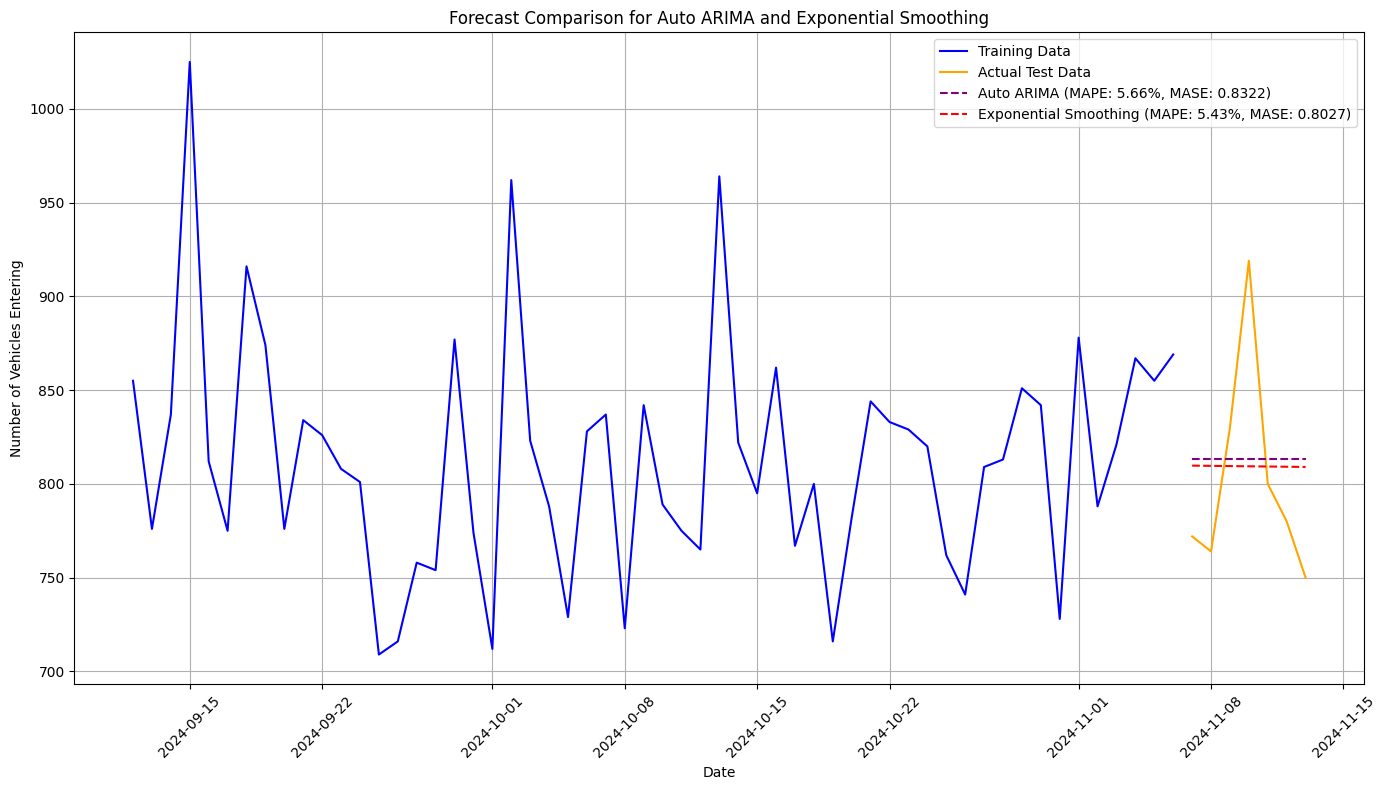

In [ ]:
from statsmodels.tsa.stattools import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def forecasting_autoarima_expsmoothing(train_data, test_data):
    # Auto ARIMA Model
    model_auto_arima = AutoARIMA(sp=30, suppress_warnings=True, seasonal=True)
    model_auto_arima.fit(train_data)
    forecast_auto_arima = model_auto_arima.predict(fh=[i for i in range(1, 8)])
    mase_arima = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_auto_arima)
    mape_arima = mean_absolute_percentage_error(test_data, forecast_auto_arima)

    # Exponential Smoothing Model
    exp_smoothing_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
    forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)
    mase_exp_smoothing = mean_absolute_scaled_error(y_true=test_data, y_pred=forecast_exp_smoothing)
    mape_exp_smoothing = mean_absolute_percentage_error(test_data, forecast_exp_smoothing)

    # Plot combined graph for Auto ARIMA and Exponential Smoothing
    plt.figure(figsize=(14, 8))
    plt.plot(train_data.index, train_data, label="Training Data", color='blue')
    plt.plot(test_data.index, test_data, label="Actual Test Data", color='orange')

    plt.plot(test_data.index, forecast_auto_arima, label=f"Auto ARIMA (MAPE: {mape_arima:.2%}, MASE: {mase_arima:.4f})", linestyle='--', color='purple')
    plt.plot(test_data.index, forecast_exp_smoothing, label=f"Exponential Smoothing (MAPE: {mape_exp_smoothing:.2%}, MASE: {mase_exp_smoothing:.4f})", linestyle='--', color='red')

    plt.title('Forecast Comparison for Auto ARIMA and Exponential Smoothing')
    plt.xlabel('Date')
    plt.ylabel('Number of Vehicles Entering')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

forecasting_autoarima_expsmoothing(train_data, test_data)


In [176]:
df=normalCleaning(df)
merged_df=mergeByTime(df)
train,test=daily_entries_plot(merged_df)

       vehicle_no           timestamp  camera_id
0        MHUN7063 2024-09-12 05:00:00          1
21       MHMY1867 2024-09-12 05:00:00          1
20       MHZF8417 2024-09-12 05:00:00          1
19       MHFU6425 2024-09-12 05:00:00          1
18       MHHB4038 2024-09-12 05:00:00          1
...           ...                 ...        ...
106658   MHPB1713 2024-11-13 23:40:00          2
106657   MHRN1774 2024-11-13 23:40:00          2
106656   MHNN2256 2024-11-13 23:40:00          2
106655   MHBU1695 2024-11-13 23:40:00          2
106663   MHWW7105 2024-11-13 23:40:00          2

[104998 rows x 3 columns]


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statesp

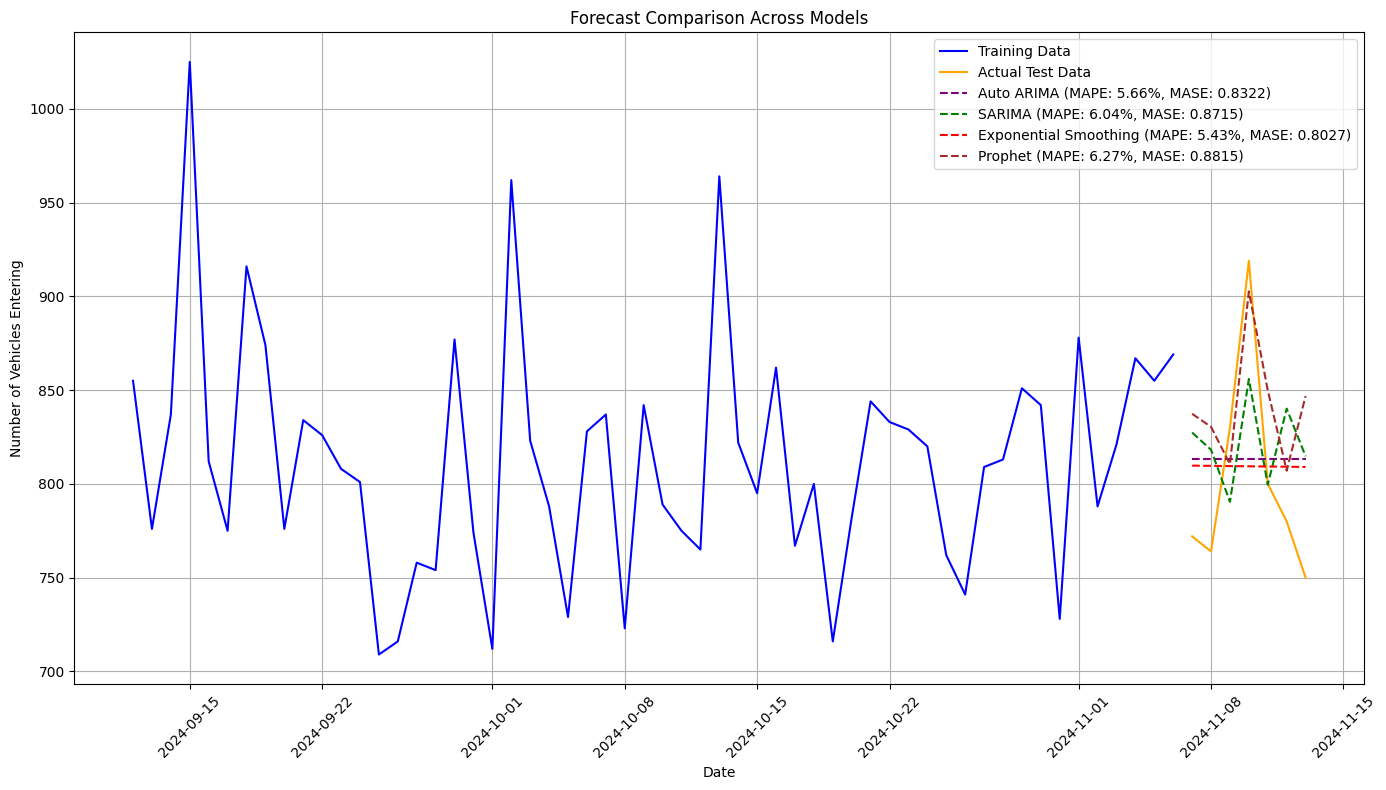

Forecasted values for the next 7 days:
            Auto ARIMA      SARIMA  Exponential Smoothing     Prophet
date                                                                 
2024-11-07  813.107143  827.365890             809.737015  837.370108
2024-11-08  813.107143  818.187171             809.618765  830.395456
2024-11-09  813.107143  790.423427             809.500514  810.562971
2024-11-10  813.107143  855.915718             809.382264  902.631089
2024-11-11  813.107143  799.561103             809.264014  849.954044
2024-11-12  813.107143  840.144466             809.145763  807.042328
2024-11-13  813.107143  814.745150             809.027513  846.876049


In [177]:
forecasting_and_plotting(train,test)

In [178]:
def timeSpent(merged_df):
    merged_df['time_spent'] = (merged_df['exit_time'] - merged_df['in_time']).dt.total_seconds() / 3600  # convert to hours
    avg_time_spent = merged_df.groupby(by=merged_df['in_time'].dt.date)['time_spent'].mean()
    y_time = pd.DataFrame(data=avg_time_spent, index=pd.to_datetime(avg_time_spent.index))
    y_train_time, y_test_time = temporal_train_test_split(y_time, test_size=7)
    # plt.figure(figsize=(12, 6))
    # plt.plot(y_time.index, y_time['time_spent'], label="Average Time Spent", color='blue')
    # # Formatting the plot
    # plt.title('Average Time Spent Per Day')
    # plt.xlabel('Date')
    # plt.ylabel('Average Time Spent (hours)')
    # plt.xticks(rotation=45)
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    return y_train_time,y_test_time


In [179]:
def predictionTimeSpent(y_train_time,y_test_time):
    
    # Cell 3: AutoARIMA Model Training and Forecasting
    model_time = AutoARIMA(sp=7, suppress_warnings=True, seasonal=True)
    model_time.fit(y=y_train_time)

    # Forecasting
    y_pred_time = model_time.predict(fh=np.arange(1, 8))

    # Calculate MASE and MAPE for AutoARIMA
    mase_arima = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time)
    mape_arima = mean_absolute_percentage_error(y_test_time, y_pred_time)

    # Print Results
    print("AutoARIMA MASE:", mase_arima)
    print("AutoARIMA MAPE:", mape_arima * 100)

    # Cell 4: SARIMAX Model Training and Forecasting
    sarimax_model = SARIMAX(endog=y_train_time, order=(2,4,3), seasonal_order=(1,1,2,9))
    sarimax_result = sarimax_model.fit(disp=False)

    # Forecasting
    y_pred_time_sarima = sarimax_result.forecast(steps=7)

    # Calculate MASE and MAPE for SARIMAX
    mase_sarima = mean_absolute_scaled_error(y_true=y_test_time, y_pred=y_pred_time_sarima)
    mape_sarima = mean_absolute_percentage_error(y_test_time, y_pred=y_pred_time_sarima)

    # Print Results
    print("SARIMAX MASE:", mase_sarima)
    print("SARIMAX MAPE:", mape_sarima * 100)
    # Cell 5: Prophet Model Training and Forecasting
    # Prepare data for Prophet (it requires a DataFrame with columns "ds" and "y")
    prophet_data = y_train_time.reset_index()
    prophet_data.columns = ["ds", "y"]

    # Fit Prophet model
    prophet_model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
    prophet_model.fit(prophet_data)

    # Forecasting
    future = prophet_model.make_future_dataframe(periods=7, freq='D')
    forecast_prophet = prophet_model.predict(future)
    forecast_values_prophet = forecast_prophet['yhat'][-7:].values

    # Calculate MASE and MAPE for Prophet
    mase_prophet = mean_absolute_scaled_error(y_true=y_test_time, y_pred=forecast_values_prophet)
    mape_prophet = mean_absolute_percentage_error(y_test_time, forecast_values_prophet)

    # Print Results
    print("Prophet MASE:", mase_prophet)
    print("Prophet MAPE:", mape_prophet * 100)
    # Cell 6: Exponential Smoothing Model Training and Forecasting
    exp_smoothing_model = ExponentialSmoothing(y_train_time, trend='add', seasonal='add', seasonal_periods=7).fit()

    # Forecasting
    forecast_exp_smoothing = exp_smoothing_model.forecast(steps=7)

    # Calculate MASE and MAPE for Exponential Smoothing
    mase_exp_smoothing = mean_absolute_scaled_error(y_true=y_test_time, y_pred=forecast_exp_smoothing)
    mape_exp_smoothing = mean_absolute_percentage_error(y_test_time, forecast_exp_smoothing)

    # Print Results
    print("Exponential Smoothing MASE:", mase_exp_smoothing)
    print("Exponential Smoothing MAPE:", mape_exp_smoothing * 100)
    # Cell 7: Visualization of Forecasts
    plt.figure(figsize=(12, 6))

    # Plot training data
    plt.plot(y_train_time.index, y_train_time, label="Training Data", color='blue')
    # Plot test data
    plt.plot(y_test_time.index, y_test_time, label="Actual Test Data", color='orange')

    # Plot forecasts from each model
    plt.plot(y_test_time.index, y_pred_time, label="AutoARIMA Forecast", linestyle='--', color='green')
    plt.plot(y_test_time.index, y_pred_time_sarima, label="SARIMAX Forecast", linestyle='--', color='red')
    plt.plot(y_test_time.index, forecast_values_prophet, label="Prophet Forecast", linestyle='--', color='purple')
    plt.plot(y_test_time.index, forecast_exp_smoothing, label="Exponential Smoothing Forecast", linestyle='--', color='brown')

    # Adding titles and labels
    plt.title(f'Forecast Comparison\n'
            f'AutoARIMA MAPE: {mape_arima * 100:.2f}%, MASE: {mase_arima:.4f} \n'
            f'SARIMAX MAPE: {mape_sarima * 100:.2f}%, MASE: {mase_sarima:.4f} \n'
            f'Prophet MAPE: {mape_prophet * 100:.2f}%, MASE: {mase_prophet:.4f} \n'
            f'Exp Smoothing MAPE: {mape_exp_smoothing * 100:.2f}%, MASE: {mase_exp_smoothing:.4f}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [180]:
train,test=timeSpent(merged_df)


AutoARIMA MASE: 0.24172740554367744
AutoARIMA MAPE: 1.5455385810359743


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aditi\minicon

SARIMAX MASE: 5.391213320485454
SARIMAX MAPE: 35.946506358569856


11:40:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prophet MASE: 1.7901104642551435
Prophet MAPE: 11.284890842821685
Exponential Smoothing MASE: 6.084128247867861
Exponential Smoothing MAPE: 40.50103373857137


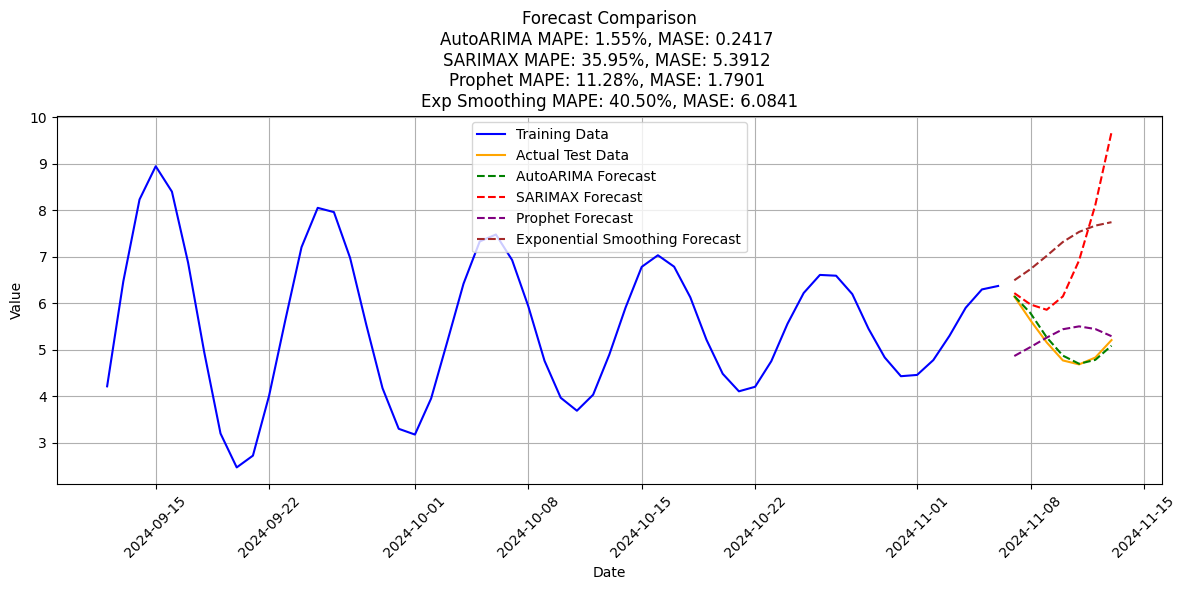

In [181]:
predictionTimeSpent(train,test)

In [182]:

def enhancedDataCleaning(df, impute_strategy='mean', outlier_method='z-score', threshold=3):
    """
    Cleans data and applies missing value imputation and outlier smoothing strategies.

    Parameters:
    df (DataFrame): Original dataframe with vehicle and timestamp data.
    impute_strategy (str): Strategy for imputing missing values ('mean', 'median', 'ffill', 'bfill').
    outlier_method (str): Method to handle outliers ('z-score', 'iqr').
    threshold (float): Threshold for outlier detection. Defaults to 3 for z-score.

    Returns:
    DataFrame: Cleaned and processed DataFrame.
    """
    # Convert to datetime and sort
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values(by='timestamp')

    # Filter for vehicles and remove rows with critical missing values
    df = df[df['vehicle_no'].notna()]
    df = df[(df['timestamp'].dt.hour >= 5) & (df['timestamp'].dt.hour < 24)]
    df = df.drop_duplicates()

    # Impute missing values based on the chosen strategy
    if impute_strategy == 'mean':
        df = df.fillna(df.mean(numeric_only=True))
    elif impute_strategy == 'median':
        df = df.fillna(df.median(numeric_only=True))
    elif impute_strategy == 'ffill':
        df = df.fillna(method='ffill')
    elif impute_strategy == 'bfill':
        df = df.fillna(method='bfill')

    # Outlier smoothing based on the chosen method
    if outlier_method == 'z-score':
        # Remove rows where z-score is beyond threshold
        z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
        df = df[(z_scores < threshold).all(axis=1)]
    elif outlier_method == 'iqr':
        # Remove rows where values are beyond the IQR bounds
        Q1 = df.quantile(0.25, numeric_only=True)
        Q3 = df.quantile(0.75, numeric_only=True)
        IQR = Q3 - Q1
        df = df[~((df.select_dtypes(include=[np.number]) < (Q1 - 1.5 * IQR)) | 
                  (df.select_dtypes(include=[np.number]) > (Q3 + 1.5 * IQR))).any(axis=1)]
        
    return df


In [183]:
def enhancedMergeByTime(df):
    """
    Merges entry and exit times for each vehicle by vehicle number.

    Parameters:
    df (DataFrame): Cleaned and processed DataFrame with vehicle and timestamp data.

    Returns:
    DataFrame: DataFrame with entry and exit times matched for each vehicle on the same date.
    """
    entry_df = df[df['camera_id'] == 1].copy()  # Entries (camera_id = 1)
    exit_df = df[df['camera_id'] == 2].copy()   # Exits (camera_id = 2)

    # Rename columns for clarity
    entry_df = entry_df.rename(columns={'timestamp': 'in_time'})
    exit_df = exit_df.rename(columns={'timestamp': 'exit_time'})

    # Merge entry and exit data on vehicle_no
    merged_df = pd.merge(entry_df[['vehicle_no', 'in_time']],
                         exit_df[['vehicle_no', 'exit_time']],
                         on='vehicle_no', 
                         how='left')

    # Ensure timestamps are on the same date by comparing the date part and filter accordingly
    merged_df = merged_df.dropna(subset=['in_time', 'exit_time'])
    merged_df = merged_df[(merged_df['in_time'].dt.date == merged_df['exit_time'].dt.date) &
                          (merged_df['in_time'] <= merged_df['exit_time'])]
    
    # Extract and add date column for further analysis
    merged_df['date'] = merged_df['in_time'].dt.date
    return merged_df


In [184]:
# Experiment 1: Mean Imputation + Z-Score Outlier Handling
df_cleaned_1 = enhancedDataCleaning(df_orignal, impute_strategy='mean', outlier_method='z-score', threshold=3)
merged_df_1 = enhancedMergeByTime(df_cleaned_1)

# Experiment 2: Median Imputation + IQR Outlier Handling
df_cleaned_2 = enhancedDataCleaning(df_orignal, impute_strategy='median', outlier_method='iqr')
merged_df_2 = enhancedMergeByTime(df_cleaned_2)

# Experiment 3: Forward Fill + Z-Score Outlier Handling (Threshold 2.5)
df_cleaned_3 = enhancedDataCleaning(df_orignal, impute_strategy='ffill', outlier_method='z-score', threshold=2.5)
merged_df_3 = enhancedMergeByTime(df_cleaned_3)

# Experiment 4: Backward Fill + IQR Outlier Handling
df_cleaned_4 = enhancedDataCleaning(df_orignal, impute_strategy='bfill', outlier_method='iqr')
merged_df_4 = enhancedMergeByTime(df_cleaned_4)




In [185]:
def runmain(merged_df):
    train,test=daily_entries_plot(merged_df)
    forecasting_and_plotting(train,test)
    train,test=timeSpent(merged_df)
    predictionTimeSpent(train,test)
    
    
    
    

In [186]:
runmain(merged_df_1)

ValueError: You must pass a freq argument as current index has none.

c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statesp

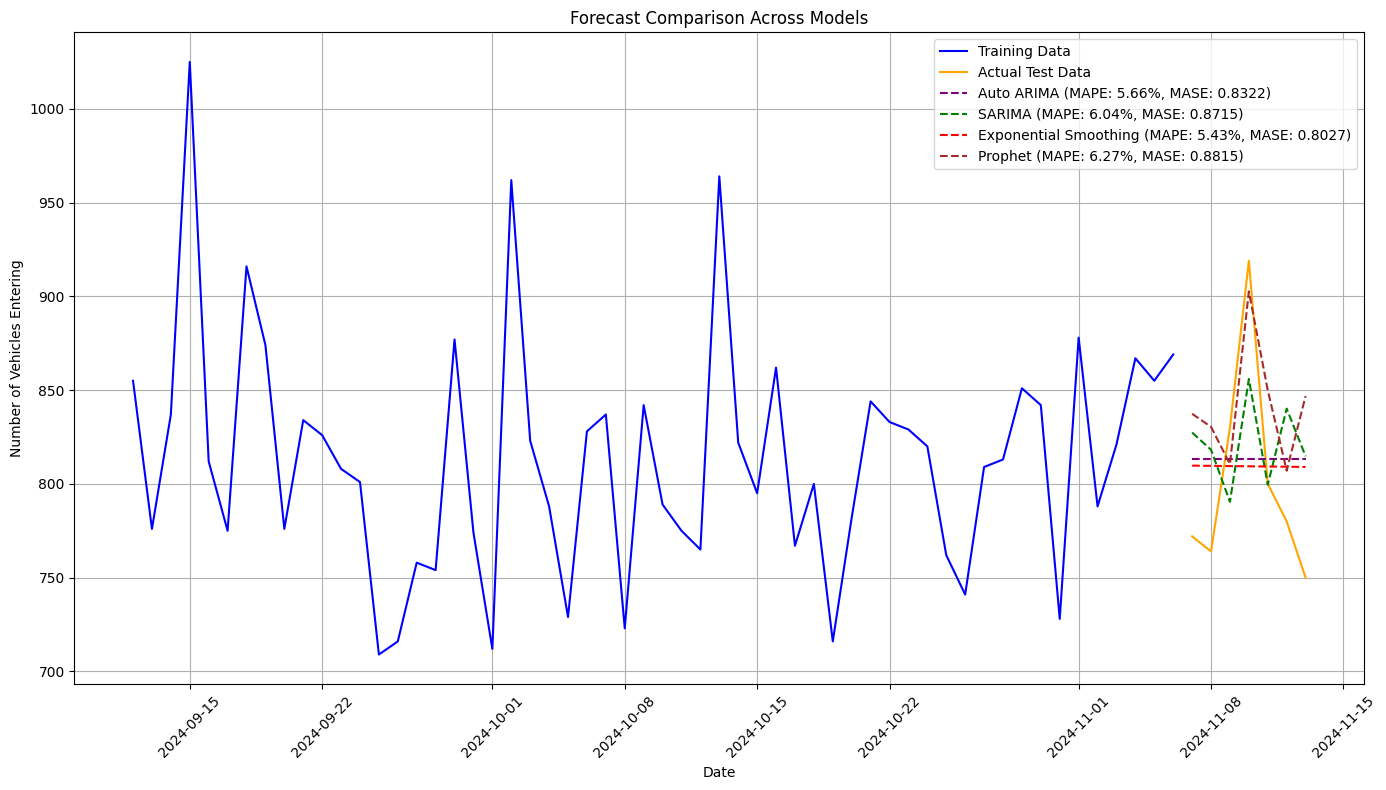

Forecasted values for the next 7 days:
            Auto ARIMA      SARIMA  Exponential Smoothing     Prophet
date                                                                 
2024-11-07  813.107143  827.365890             809.737015  837.370108
2024-11-08  813.107143  818.187171             809.618765  830.395456
2024-11-09  813.107143  790.423427             809.500514  810.562971
2024-11-10  813.107143  855.915718             809.382264  902.631089
2024-11-11  813.107143  799.561103             809.264014  849.954044
2024-11-12  813.107143  840.144466             809.145763  807.042328
2024-11-13  813.107143  814.745150             809.027513  846.876049
AutoARIMA MASE: 0.24172740554367744
AutoARIMA MAPE: 1.5455385810359743


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aditi\minicon

SARIMAX MASE: 5.391213320485454
SARIMAX MAPE: 35.946506358569856
Prophet MASE: 1.7901104642551435
Prophet MAPE: 11.284890842821685


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Exponential Smoothing MASE: 6.084128247867861
Exponential Smoothing MAPE: 40.50103373857137


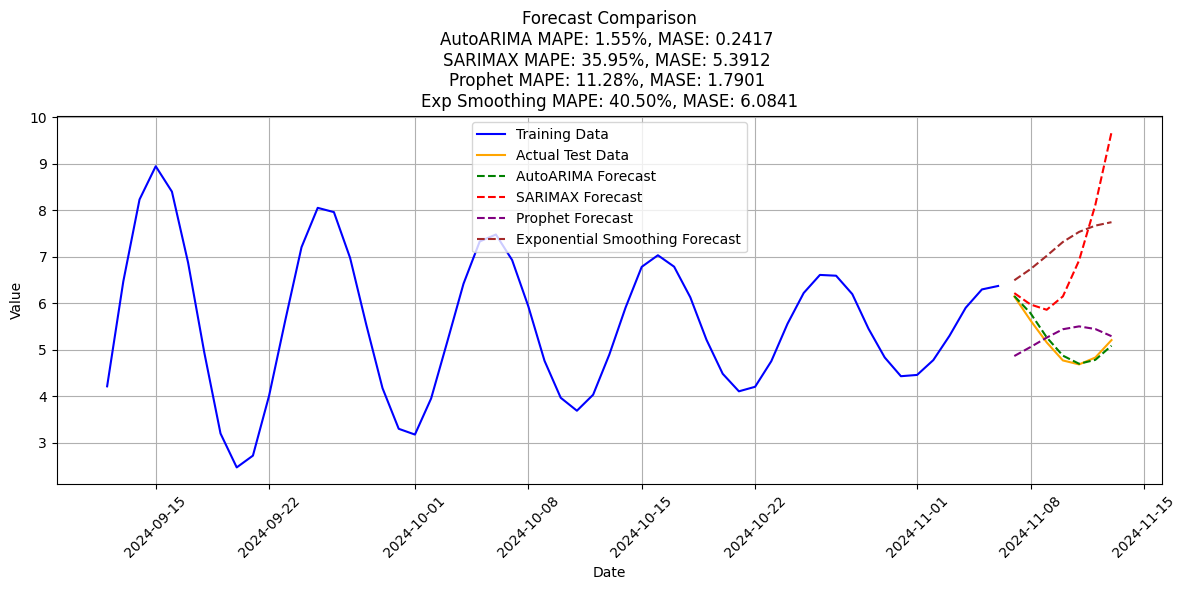

In [165]:
runmain(merged_df_2)

c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statesp

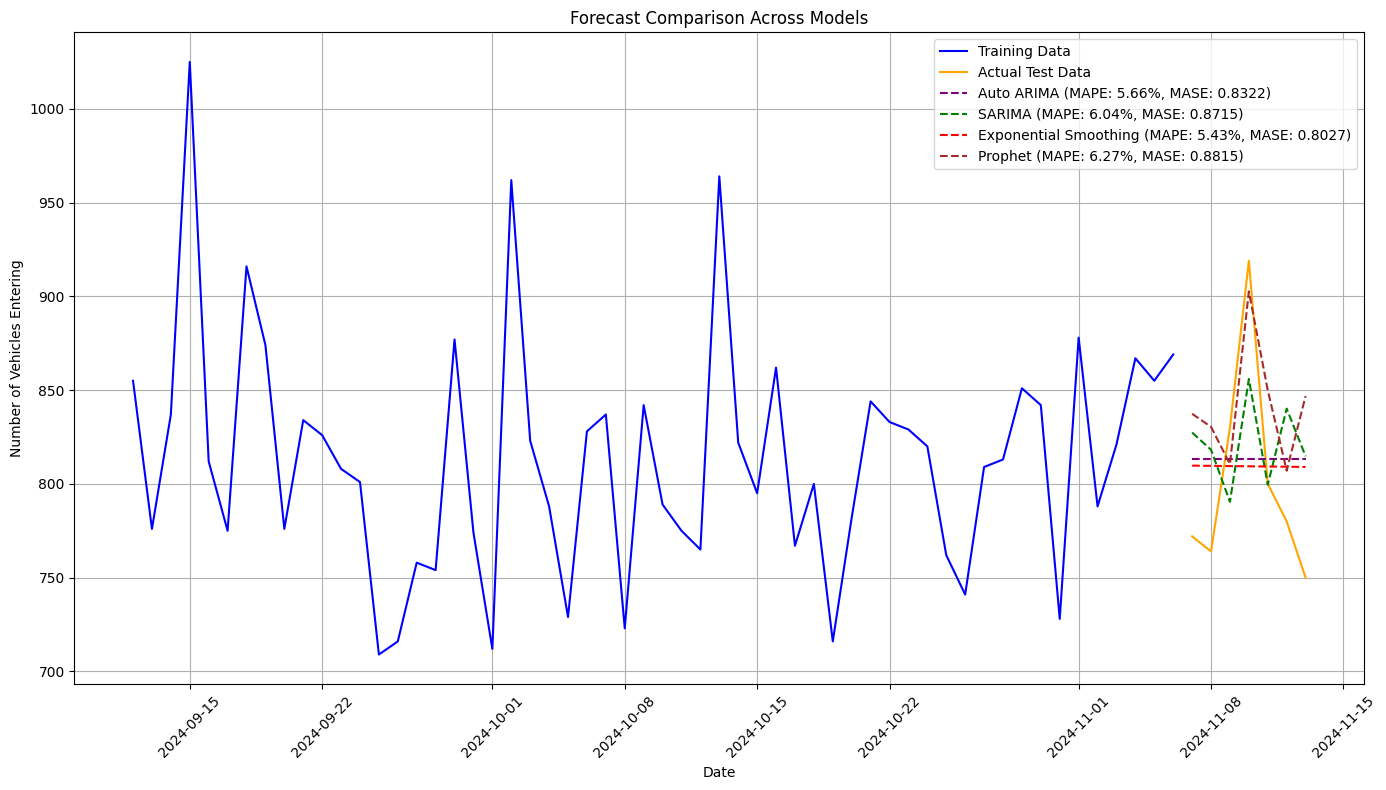

Forecasted values for the next 7 days:
            Auto ARIMA      SARIMA  Exponential Smoothing     Prophet
date                                                                 
2024-11-07  813.107143  827.365890             809.737015  837.370108
2024-11-08  813.107143  818.187171             809.618765  830.395456
2024-11-09  813.107143  790.423427             809.500514  810.562971
2024-11-10  813.107143  855.915718             809.382264  902.631089
2024-11-11  813.107143  799.561103             809.264014  849.954044
2024-11-12  813.107143  840.144466             809.145763  807.042328
2024-11-13  813.107143  814.745150             809.027513  846.876049
AutoARIMA MASE: 0.24172740554367744
AutoARIMA MAPE: 1.5455385810359743


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aditi\minicon

SARIMAX MASE: 5.391213320485454
SARIMAX MAPE: 35.946506358569856


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Prophet MASE: 1.7901104642551435
Prophet MAPE: 11.284890842821685
Exponential Smoothing MASE: 6.084128247867861
Exponential Smoothing MAPE: 40.50103373857137


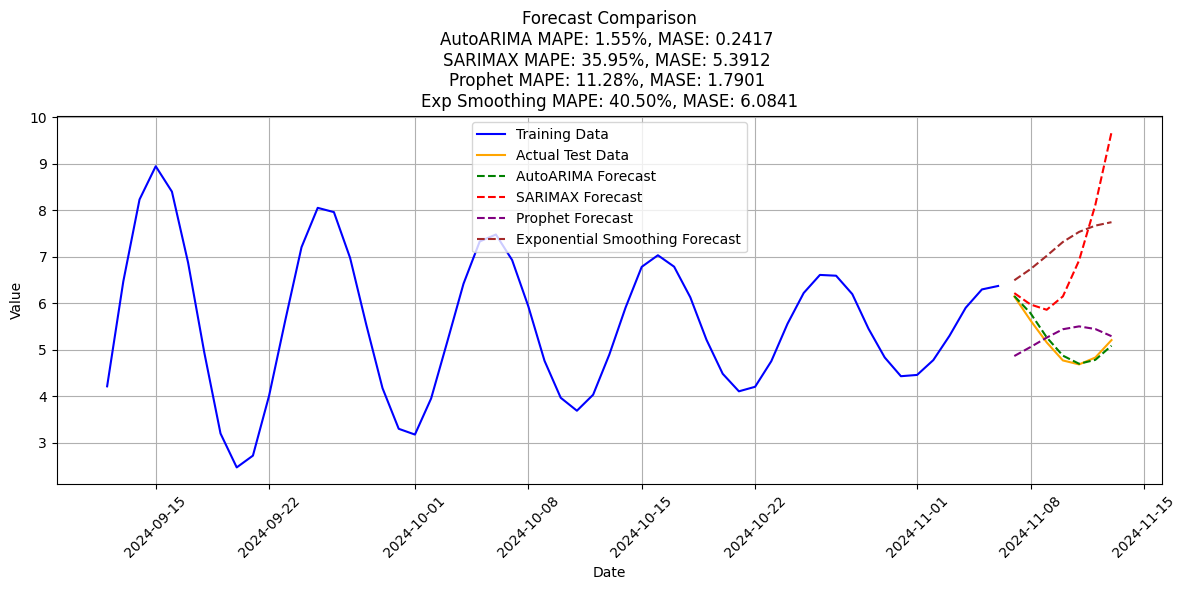

In [166]:
runmain(merged_df_3)

c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statesp

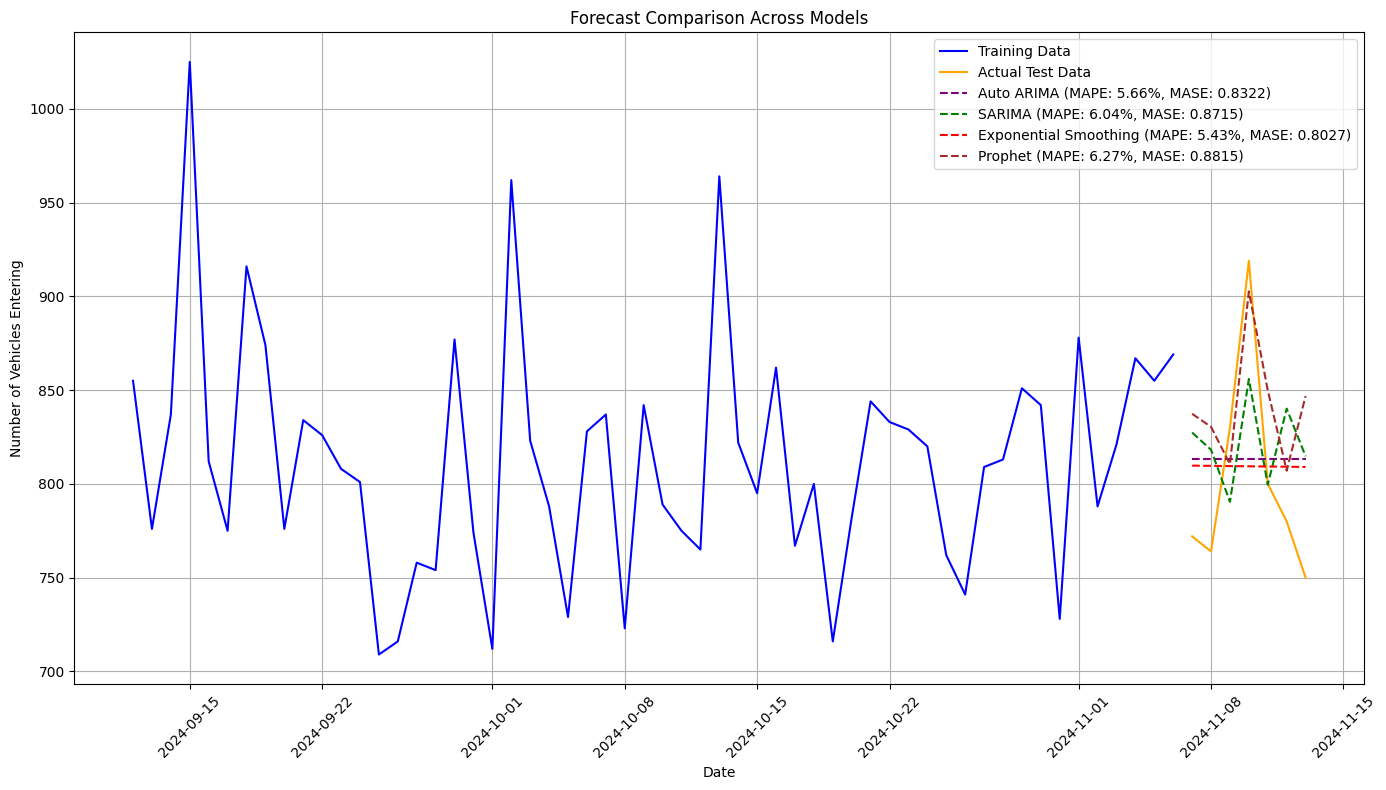

Forecasted values for the next 7 days:
            Auto ARIMA      SARIMA  Exponential Smoothing     Prophet
date                                                                 
2024-11-07  813.107143  827.365890             809.737015  837.370108
2024-11-08  813.107143  818.187171             809.618765  830.395456
2024-11-09  813.107143  790.423427             809.500514  810.562971
2024-11-10  813.107143  855.915718             809.382264  902.631089
2024-11-11  813.107143  799.561103             809.264014  849.954044
2024-11-12  813.107143  840.144466             809.145763  807.042328
2024-11-13  813.107143  814.745150             809.027513  846.876049
AutoARIMA MASE: 0.24172740554367744
AutoARIMA MAPE: 1.5455385810359743


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aditi\minicon

SARIMAX MASE: 5.391213320485454
SARIMAX MAPE: 35.946506358569856
Prophet MASE: 1.7901104642551435
Prophet MAPE: 11.284890842821685


c:\Users\aditi\miniconda3\envs\dai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Exponential Smoothing MASE: 6.084128247867861
Exponential Smoothing MAPE: 40.50103373857137


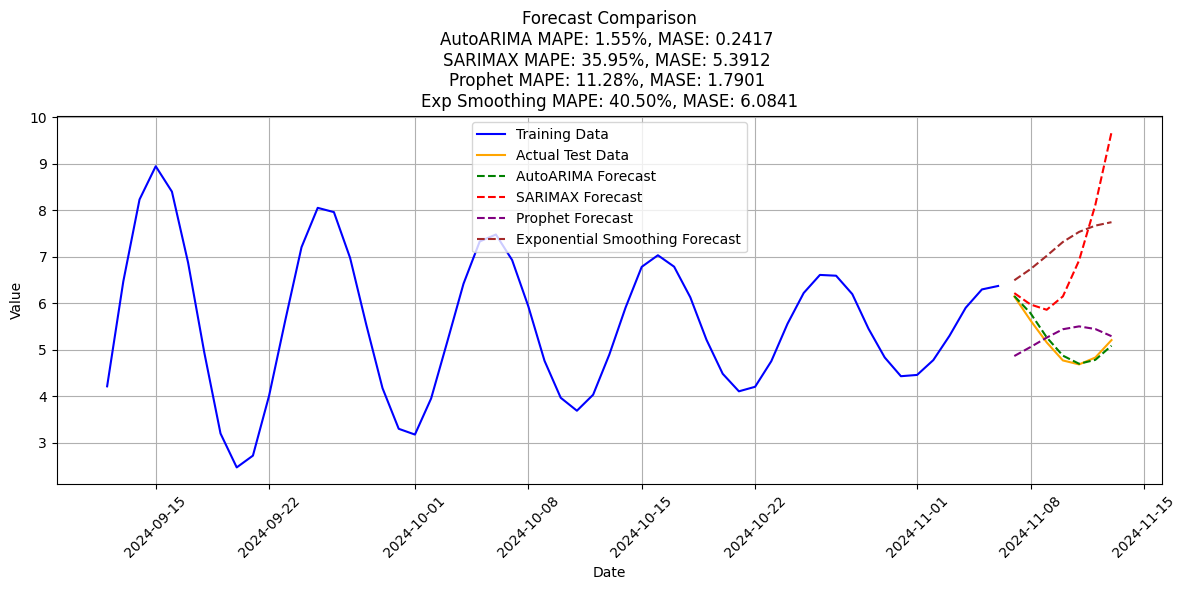

In [167]:
runmain(merged_df_4)